In [1]:
import numpy as np
import astropy.units as units
import matplotlib.pyplot as plt
import astropy.constants as csts
import scipy.constants as constants

The Rabi rate is given by  
$\Omega = \frac{\vec{d}\cdot \vec{E}_0}{\hbar}$,  
where $\vec{d}$ is the transition dipole moment and $\vec{E}_0$ is the vector electric field amplitude, including polarization.

The time averaged energy density of an electromagnetic wave is given by:  
$\langle U \rangle = \frac{n^2\epsilon_0}{2}|E|^2$.

The intensity is then given by:  
$I_{avg} = \frac{c\epsilon_0 E_0^2}{2}$,  
and the power by:  
$P = |I| A_{laser}$

In [91]:
@units.quantity_input
def calc_D_eff(Gamma: units.Hz, frequency: units.Hz):
    c = csts.c
    e0 = csts.eps0
    hbar = csts.hbar
    return np.sqrt( (Gamma) * 3*np.pi * e0 *hbar * c**3 / (2*np.pi * frequency)**3 ).decompose()

In [92]:
# Calculate effective dipole moment for the optical transitions
Gamma = units.Hz/100e-9 #Natural linewidth in 2*pi*Hz
f = units.Hz * csts.c.value/271.7e-9
D_eff = calc_D_eff(Gamma, f)
D_eff

<Quantity 2.66755059e-30 A m s>

In [4]:
@units.quantity_input
def calculate_power_needed(Omega: units.Hz, ME, σx: units.m, σy: units.m, D_TlF: units.A*units.s*units.m):
    """
    Function to calculate the power required to get peak Rabi rate Omega
    for a transition with given matrix element with a gaussian spatial profile
    """
    c = csts.c
    epsilon_0 = csts.eps0
    
    #Calculate the electric field required
    E =  Omega*csts.hbar/(ME*D_TlF)

    #Convert E to peak intensity
    I = 1/2 * c * epsilon_0 * E**2

    #Convert power to amplitude of the Gaussian
    P = I * (2*np.pi *σx*σy)

    return P.to(units.W)

In [221]:
σx = 2642*1e-6/4 * units.m # σ width of the laser.
σx = 0.8*units.mm
σy = 1.5*2*5265*1e-6/4 * units.m # σ height of the laser

# σx, σy = 1e-3 * units.m, 1e-3 * units.m

# ME_main is the coupling element from the main ground state to the main excited state
ME_main = -0.39444661441301954+0j
calculate_power_needed(2*Gamma, ME_main.real, σx, σy, D_eff).to(units.mW)
calculate_power_needed(2*Gamma, ME_main.real, σx, σy, D_eff).to(units.mW)/(2*np.pi*σx*σy).to(units.cm**2)

<Quantity 533.27344311 mW / cm2>

In [222]:
calculate_power_needed(2*np.pi*2*units.MHz, ME_main.real, σx, σy, D_eff).to(units.mW)#/(2*np.pi*σx*σy).to(units.cm**2)

<Quantity 41.78680702 mW>

In [126]:
σx

<Quantity 0.0006605 m>

In [128]:
calculate_power_needed(2*Gamma, ME_main.real, σx, σy, D_eff).to(units.mW)

<Quantity 87.39010994 mW>

In [129]:
calculate_power_needed(6*Gamma*ME_main.real, ME_main.real, σx, σy, D_eff).to(units.mW)

<Quantity 122.37177534 mW>

In [130]:
calculate_power_needed(6.5*Gamma*ME_main.real, ME_main.real, σx, σy, D_eff).to(units.mW)

<Quantity 143.61687523 mW>

$\Omega$ seems to be rather large for our power. Must be an error somewhere, but haven't been able to find it yet.

In [131]:
@units.quantity_input
def sigma_to_fwhm(σ: units.m):
    return 2*np.sqrt(2*np.log(2))*σ

In [132]:
sigma_to_fwhm(σx)

<Quantity 0.00155536 m>

### Verifying 2D Gaussian Integral

In [133]:
def gaussian_2d(y,z,μy,μz,σy,σz):
    a = (y-μy)**2/(2*σy**2)
    b = (z-μz)**2/(2*σz**2)
    return np.exp(-(a+b))

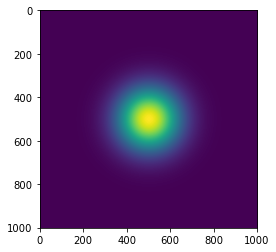

In [134]:
xi,yi = np.linspace(-5,5,1001)*σx, np.linspace(-5,5,1001)*σy
X,Y = np.meshgrid(xi,yi)
vals = gaussian_2d(X,Y,0,0,σx, σy)
plt.imshow(vals)

In [135]:
# numeric integral to verify
vals.sum()*np.diff(xi)[0]*np.diff(yi)[0]

<Quantity 1.63874675e-05 m2>

In [136]:
# analytic integral
2*np.pi*σx*σy

<Quantity 1.63874858e-05 m2>

<ipython-input-143-13800d7fc14d>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X.value, Y.value, vals.value)


<Quantity 79.98845101 mW>

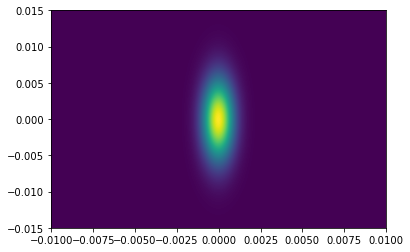

In [143]:
xi,yi = np.linspace(-10,10,2001)*1e-3*units.m, np.linspace(-15,15,2001)*1e-3*units.m
X,Y = np.meshgrid(xi,yi)
vals = gaussian_2d(X,Y,0,0,σx, σy)*80*units.mW/(2*np.pi*σx*σy)
plt.pcolormesh(X.value, Y.value, vals.value)
np.sum(vals)*np.diff(xi)[0]*np.diff(yi)[0]

In [147]:
@units.quantity_input
def calculate_rabi_rate(I: units.mW/units.cm**2, ME, D_TlF: units.A*units.s*units.m):
    """
    Function to calculate the power required to get peak Rabi rate Omega
    for a transition with given matrix element with a gaussian spatial profile
    """
    c = csts.c
    epsilon_0 = csts.eps0
    
    E = np.sqrt(I*2/(c*epsilon_0))
    Omega = np.abs(E/(csts.hbar/(ME*D_TlF)))
    
    return Omega.to(units.MHz)

### RC laser

In [223]:
peak_intensity = (80*units.mW/(2*np.pi*σx*σy)).to(units.mW/units.cm**2)
peak_intensity

<Quantity 403.05145449 mW / cm2>

In [224]:
calculate_rabi_rate(peak_intensity, ME_main, D_eff)/(2*np.pi)

<Quantity 2.7672946 MHz>

In [225]:
(calculate_rabi_rate(peak_intensity, ME_main, D_eff)/Gamma).decompose()

<Quantity 1.73874248>

### $\mu_{1\leftrightarrow2}$

In [183]:
μ_ME_main = 0.4934218597083703
D_TlF = 4.2282 * 3.33564e-30 * units.C * units.m
peak_intensity = 400*units.mW/(2*np.pi*(1.27*units.cm)**2)

(np.sqrt(2*peak_intensity/(csts.eps0*csts.c))*D_TlF/2/csts.hbar).to(units.MHz)/(2*np.pi) * μ_ME_main

<Quantity 2.86374061 MHz>

### $\mu_{2\leftrightarrow3}$

In [185]:
D_TlF = 4.2282 * 3.33564e-30 * units.C * units.m
peak_intensity = 316*units.mW/(2*np.pi*(1.27*units.cm)**2)

(np.sqrt(2*peak_intensity/(csts.eps0*csts.c))*D_TlF/2/csts.hbar).to(units.MHz)/(2*np.pi) * μ_ME_main

<Quantity 2.54534833 MHz>

### Detection

In [190]:
peak_intensity = (50*units.mW/(2*np.pi*2*units.mm * 0.5*units.cm)).to(units.mW/units.cm**2)
peak_intensity

<Quantity 79.57747155 mW / cm2>

In [191]:
calculate_rabi_rate(peak_intensity, ME_main, D_eff)/(2*np.pi)

<Quantity 1.22961801 MHz>